In [1]:
import tensorflow as tf
from helpers import *
from convnet_experiment import *

In [2]:
%matplotlib inline

In [3]:
DATA_DIR = 'netdata'
train = np.load(os.path.join(DATA_DIR, 'standardized_train.npy'))
train_labels = np.load(os.path.join(DATA_DIR, 'labels_train.npy'))
test = np.load(os.path.join(DATA_DIR, 'standardized_test.npy'))
test_labels = np.load(os.path.join(DATA_DIR, 'labels_test.npy'))

In [4]:
RUN_NAME = 'CRPS-MODEL-3.0'
DATA_DIR = 'netdata'
ITERS = 100000
START_ITER = 0
MODEL_LOAD_PATH = None
PIC_WIDTH = 32
### Architectural Hyperparameters
DEPTH_1 = 8         # The output depth of the first convolutional layer
DEPTH_2 = 16         # The output depth of the second convolutional layer
DEPTH_3 = 20         # The output depth of the second convolutional layer
DEPTH_4 = 24        # The output depth of the second convolutional layer
DEPTH_5 = 30        # The output depth of the second convolutional layer
DEPTH_6 = 40        # The output depth of the second convolutional layer

NUM_OUTPUTS = 25    # Number of output classes in the softmax layer
KERNEL_X = 3         # The width of the convolution kernel (using same for 1st and 2nd layers)
KERNEL_Y = 3         # The height of the convolution kernel (using same for 1st and 2nd layers)
mu = 0.0001
LEARNING_RATE = 1e-4

REGULARIZE_BIAS = False

NUM_INPUTS = 9  
NUM_REPS = 144

TRAIN_LABEL_NOISE_STD = 2.
TRAIN_LABEL_SMOOTHING_STD = 0.
DATA_AUGMENTATION = True
DIASTOLE = False

###########################################
NUM_INPUTS = 9       # Number of input channels
NUM_OUTPUTS = 2
NUM_REPS = 144
TRAIN_LABEL_NOISE_STD = 0.0001
TRAIN_LABEL_SMOOTHING_STD = 0.
LEARNING_RATE = 1e-3
mu = 0.05
DATA_AUGMENTATION = True
RUN_NAME = 'TWO-CLASS-EXP'
DEPTH_1 = 4         # The output depth of the first convolutional layer
DEPTH_2 = 4         # The output depth of the second convolutional layer
DEPTH_3 = 4         # The output depth of the second convolutional layer
DEPTH_4 = 2        # The output depth of the second convolutional layer
DEPTH_5 = 2        # The output depth of the second convolutional layer
DEPTH_6 = 2   

In [5]:
graph = tf.Graph()
with graph.as_default():
    ####################################### INPUT/OUTPUT PLACEHOLDERS ##############################################
    x = tf.placeholder(tf.float32, shape=[None, PIC_WIDTH, PIC_WIDTH, NUM_INPUTS]) #Placeholder for the input images
    y_ = tf.placeholder(tf.float32, shape=[None, NUM_OUTPUTS]) #Placeholder for the label cdfs
    ####################################### FIRST CONVOLUTIONAL LAYER ##############################################
    # The weight tensor has dimensions [kernel_size_x, kernel_size_y, num_input_channels, num_output_channels]
    W_conv1 = weight_variable([KERNEL_X, KERNEL_Y, NUM_INPUTS, DEPTH_1])
    b_conv1 = bias_variable([DEPTH_1])
    #Take the input image, reshape it to a 4D tensor with dimensions: [_, image_width, image_height, num_channels]
    #x_image = tf.reshape(x, [-1,32,32,3])
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    ####################################### SECOND CONVOLUTIONAL LAYER ##############################################
    W_conv2 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_1, DEPTH_2])
    b_conv2 = bias_variable([DEPTH_2])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    ####################################### THIRD CONVOLUTIONAL LAYER ##############################################
    W_conv3 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_2, DEPTH_3])
    b_conv3 = bias_variable([DEPTH_3])

    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    ####################################### FOURTH CONVOLUTIONAL LAYER ##############################################
    W_conv4 = weight_variable([KERNEL_X, KERNEL_Y, DEPTH_3, DEPTH_4])
    b_conv4 = bias_variable([DEPTH_4])

    h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
    h_pool4 = max_pool_2x2(h_conv4)
    # ####################################### FIFTH CONVOLUTIONAL LAYER ##############################################
    #This layer uses a 1x1 convolution
    W_conv5 = weight_variable([1, 1, DEPTH_4, DEPTH_5])
    b_conv5 = bias_variable([DEPTH_5])

    h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
    h_pool5 = tf.nn.avg_pool(h_conv5,ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    h_pool5_flat = tf.reshape(h_pool5, [-1, DEPTH_5])
    ############################################### DROPOUT ##########################################################
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_pool5_flat, keep_prob)
    ############################################# SOFTMAX OUTPUT LAYER ###############################################
    W_fc2 = weight_variable([DEPTH_5, NUM_OUTPUTS])
    b_fc2 = bias_variable([NUM_OUTPUTS])

    y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    ##################################### SETTING UP THE OPTIMISATION PROBLEM #####################################
    cross_entropy = -tf.reduce_sum(y_*tf.log(y+1e-12))
    loss = cross_entropy + mu*(tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2)
                                + tf.nn.l2_loss(W_conv3) + tf.nn.l2_loss(W_conv4)
                                + tf.nn.l2_loss(W_conv5) + tf.nn.l2_loss(W_fc2))

    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    xentrop_summ = tf.scalar_summary("Cross Entropy", loss)
    accuracy_summ = tf.scalar_summary("Accuracy", accuracy)

## Run the relevant data through the classifier, in this case I'm running the 200 test cases

In [6]:
MODEL_LOAD_PATH = 'TWO-CLASS-EXP/model-13000'
predictions = []
with tf.Session(graph=graph) as session:
    saver = tf.train.Saver()
    saver.restore(session, MODEL_LOAD_PATH)
    for i in range(200):
        if i%40 == 0:
            print 'Patient ', i
        Xt,yt = batch(test[:,i:i+1], [])
        pred = session.run([y], feed_dict={x: Xt, keep_prob: 1.0})[0]
        ### Average over all 144 predictions
        pred = np.mean(pred, axis=0)
        predictions.append(pred)
    predictions = np.array(predictions)
class_pred = predictions[:,1]

Patient  0
Patient  40
Patient  80
Patient  120
Patient  160


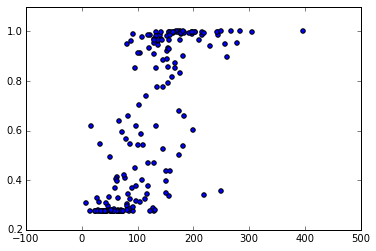

In [8]:
plt.scatter(test_labels, class_pred)

## Code for smoothing the CDFs

In [ ]:
width = 20
h = np.ones(width)/float(width)
smooth_cdfs = np.zeros_like(cdfs)
for i in range(cdfs.shape[0]):
    smoos = np.convolve(h,cdfs[i])
    smoos = smoos[width/2:-(width/2 - 1)]
    smoos[-(width/2):] = 1.
    smooth_cdfs[i,:] = smoos

smooth_cdfs.shape